In [2]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sentence_transformers import SentenceTransformer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout, Activation, Conv1D, BatchNormalization, MaxPool1D
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.layers import Bidirectional

[nltk_data] Downloading package stopwords to /home/pirate/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/pirate/.local/share/virtualenvs/ai_prog_lec-IUo41nw4/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-12-24 21:39:57.362741: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-24 21:39:58.384240: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory


In [3]:
em_model = SentenceTransformer('/mnt/wine/ai_models/sentence_transformers/sentence-transformers_paraphrase-multilingual-mpnet-base-v2/')

In [4]:
data = pd.read_csv('labeled_data.csv')
data

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [5]:
data = data[["tweet", "class"]]
data

,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1
...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,1
24779,"you've gone and broke the wrong heart baby, an...",2
24780,young buck wanna eat!!.. dat nigguh like I ain...,1
24781,youu got wild bitches tellin you lies,1


In [6]:
def clean(text):
    text = text.lower() # make all text lowercase
    text = re.sub("https?://\w+\.\w+\.\w+", "", text) # removes all links
    text = re.sub('@[\w]+','',text) # removes @Mentions
    text = re.sub('#[\w]+','',text) # removes hashtags
    text = re.sub('rt','',text) #removes rt (retweet) sign
    text = re.sub("[^a-z ]+", "", text) # removes all non-alphabetic characters
    return text

In [7]:
data['tweet'] = data['tweet'].apply(clean) 
data.head()

/tmp/ipykernel_3931963/1252549931.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tweet'] = data['tweet'].apply(clean)


,tweet,class
0,as a woman you shouldnt complain about clea...,2
1,boy dats coldtyga dwn bad for cuffin dat ho...,1
2,dawg you ever fuck a bitch and she sta to...,1
3,she look like a tranny,1
4,the shit you hear about me might be true or...,1


In [8]:
def categergorical_to_binary(labels):
    for i, label in enumerate(labels):
        if label == 0:
            labels[i] = 1
        elif label == 2:
            labels[i] = 0
    return labels

In [9]:
# Split dataset into training and validation set
train_df = data.sample(frac=0.9)
val_df = data.drop(train_df.index)

# split text and labels
train_sentences = train_df["tweet"].to_numpy()
train_labels = train_df["class"].to_numpy()
val_sentences = val_df["tweet"].to_numpy()
val_labels = val_df["class"].to_numpy()

In [10]:
def get_embeddings(sentences):
    embs = []
    for sentence in sentences:
        embs.append(em_model.encode(sentence))
    return embs

In [11]:
train_embs = get_embeddings(train_sentences)
val_embs = get_embeddings(val_sentences)
train_embs = np.array(train_embs)
val_embs = np.array(val_embs)

In [12]:
train_embs.shape, val_embs.shape

((22305, 768), (2478, 768))

In [13]:
train_embs = np.expand_dims(train_embs, axis=1)
val_embs = np.expand_dims(val_embs, axis=1)
train_embs.shape, val_embs.shape

((22305, 1, 768), (2478, 1, 768))

In [14]:
train_labels = categergorical_to_binary(train_labels)
val_labels = categergorical_to_binary(val_labels)

In [27]:
def build_model():
    inputs = Input(name='the_input', shape=(1,768), dtype='float32')
    
    x = Dense(768, activation='tanh')(inputs)
    x = Dense(384, activation='tanh')(x)
    
    x = Conv1D(128, 5, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)

    
    x = Dense(128, activation='tanh')(x)
    x = Bidirectional(LSTM(128, return_sequences=True), merge_mode='sum')(x)
    x = Bidirectional(LSTM(64), merge_mode='concat')(x)
    x = Dropout(0.2)(x)
    
    x = Dense(64, activation='tanh')(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='tanh')(x)
    
    x = Dense(1, activation='sigmoid')(x)
    return Model(inputs=inputs, outputs=x)

In [34]:
model = build_model()
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 the_input (InputLayer)      [(None, 1, 768)]          0         
                                                                 
 dense_24 (Dense)            (None, 1, 768)            590592    
                                                                 
 dense_25 (Dense)            (None, 1, 384)            295296    
                                                                 
 conv1d_4 (Conv1D)           (None, 1, 128)            245888    
                                                                 
 batch_normalization_4 (Batc  (None, 1, 128)           512       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 1, 128)            0         
                                                           

In [46]:
from tensorflow.keras.optimizers import Adam

In [35]:
opt = Adadelta(learning_rate=1)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [36]:
EPOCHS = 5
history = model.fit(train_embs,
                    train_labels,
                    validation_data=(val_embs, val_labels),
                    verbose=1,
                    batch_size=16,
                    epochs=EPOCHS)

Epoch 1/5
1395/1395 [==============================] - 42s 24ms/step - loss: 0.2153 - accuracy: 0.9102 - val_loss: 0.1776 - val_accuracy: 0.9213
Epoch 2/5
1395/1395 [==============================] - 28s 20ms/step - loss: 0.1741 - accuracy: 0.9271 - val_loss: 0.1665 - val_accuracy: 0.9330
Epoch 3/5
1395/1395 [==============================] - 29s 21ms/step - loss: 0.1635 - accuracy: 0.9313 - val_loss: 0.1560 - val_accuracy: 0.9391
Epoch 4/5
1395/1395 [==============================] - 32s 23ms/step - loss: 0.1558 - accuracy: 0.9351 - val_loss: 0.1663 - val_accuracy: 0.9326
Epoch 5/5
1395/1395 [==============================] - 32s 23ms/step - loss: 0.1494 - accuracy: 0.9363 - val_loss: 0.1470 - val_accuracy: 0.9415


In [38]:
model.save_weights('model_finall.hdf5')

In [ ]:
!pip install plot_keras_history

In [20]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

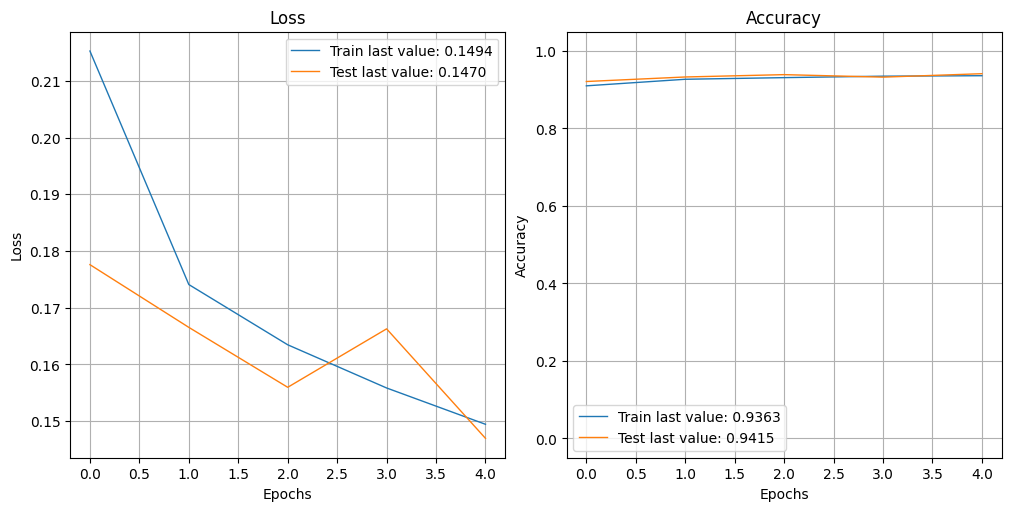

In [37]:
show_history(history)
plot_history(history, path="standard.png")
plt.close()

In [22]:
def predict(text):
    text = clean(text)
    #text = remove_stopwords(text)
    embeddings = em_model.encode([text])
    embeddings = np.expand_dims(embeddings, axis=1)
    pred = model.predict(embeddings)
    print(pred)
    if pred > 0.5:
        return "Hate speech/offensive language"
    else:
        return "normal"

In [27]:
predict("hitler was a good, he killed all jews")

1/1 [==============================] - 0s 32ms/step
[[0.6107693]]


'Hate speech/offensive language'